# Image Classification Problem
The task of the challenge was to classify images of leaves within two classes: either healthy or unhealthy. The images were associated with respective labels. Each image of size 96 x 96 was stored on 3 RGB channels.


## Setup


### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ANN challenge

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1U3uzkd-O_denCNDC3IVwKl6jH3F_gdl7/ANN challenge


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import pandas as pd

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns


## Dataset

### Load and process the dataset

In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'public_data.zip' file if the 'unzip' flag is True
if unzip:
    !unzip public_data.zip


Loading the dataset.

In [ ]:
npz=np.load('public_data.npz', allow_pickle=True)

data=npz['data']
labels=npz['labels']
data=data.astype(np.uint8)

#### Data Cleaning (skipped if running with preprocessed dataset)

##### Calculating similarity scores and average similarity score to find outliers based on histogram profile

In [ ]:
def similarity(image1, image2):

  hist_img1 = cv2.calcHist([image1], [0,1,2], None, [ 256,256, 256], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

  hist_img2 = cv2.calcHist([image2], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

  # Find the metric value
  metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)

  return metric_val

We compare histograms of the images in the dataset to look for outliers.

In [ ]:
avg=[]
# n=data.shape[0]
n=20 #define how many images you want to inspect
for i in range(n):
  sum=0
  hist_img1 = cv2.calcHist([data[i]], [0,1,2], None, [ 256,256, 256], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  for j in range(100):
    hist_img2 = cv2.calcHist([data[j]], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Find the metric value
    metric_val = cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_CORREL)
    sum=sum+abs(round(metric_val, 2))
  avg.append(sum/data.shape[0])



Plotting mean average similarity between each image and the rest of the dataset

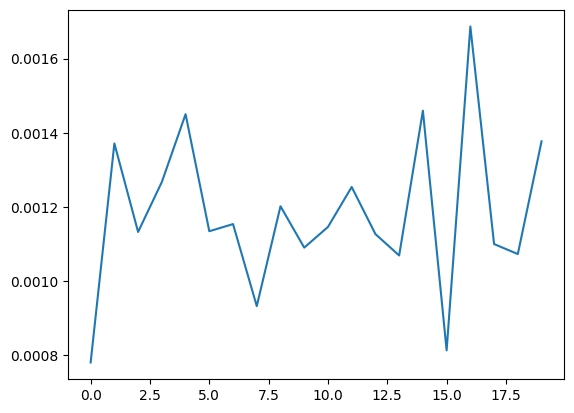

0.001181057692307691


In [ ]:
import statistics

plt.plot(range(n),avg)
plt.show()

mean_avg=statistics.fmean(avg)
print(mean_avg)


We can observe that the tonal distributions (histograms) of some images deviate from other images in the database.

In [ ]:
df=pd.DataFrame(avg)
df.columns=["average"]
df

,average
0,0.000781
1,0.001371
2,0.001133
3,0.001267
4,0.001450
5,0.001135
6,0.001154
7,0.000933
8,0.001202
9,0.001090


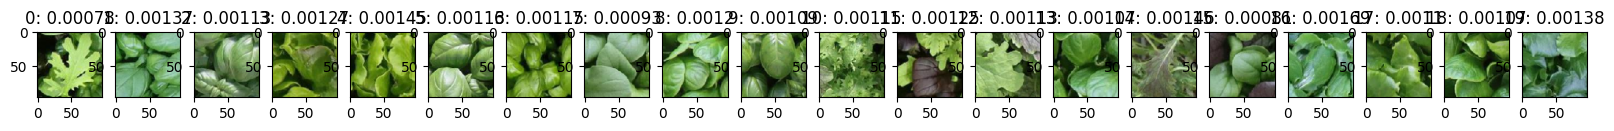

In [ ]:
fig, axes = plt.subplots(1, len(df.index), figsize=(20,80))
j=0
# for i in range(20):
for i, row in df.iterrows():
    ax = axes[j]
    ax.imshow(data[i], cmap='gray')
    ax.set_title(f'{i}: {round(avg[i],5)}')

    j+=1
plt.show()

We observed that our dataset consists images of leaves but some also some messy data. Average similarities was not enough to eliminate outliers and messy data. We found 2 types of unwanted images: shrek and trololo. In the next steps we removed them from the dataset.

##### Removing 2 types of messy data from the dataset

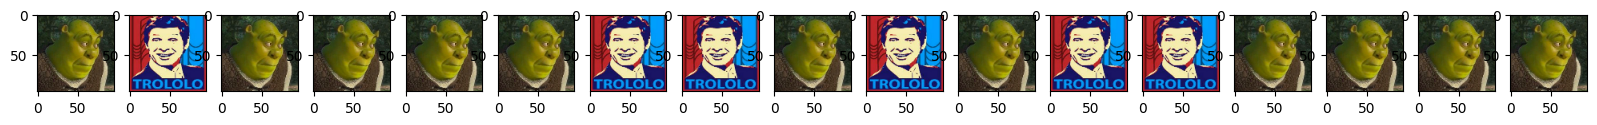

In [ ]:
outliers_samples=[137, 338,207,58, 95, 1028, 1044, 1101,3033, 3049, 3055, 3086, 3108, 3105,3144,3155,3286]

images=outliers_samples
fig, axes = plt.subplots(1, len(images), figsize=(20,80))
j=0
for item in images:
    ax = axes[j]
    ax.imshow(data[item], cmap='gray')
    j+=1
plt.show()


In [ ]:
similarity(data[338],data[1044])

1.0

In [ ]:
outliers_shrek=[]

n=data.shape[0]
for i in range(n):
  if similarity(data[i],data[137])==1.0:
    outliers_shrek.append(i)

outliers_trololo=[]
for i in range(n):
  if similarity(data[i],data[338])==1.0:
    outliers_trololo.append(i)

#Results saved in dataset_cleaned.npz

In [ ]:
len(outliers_trololo)

98

In [ ]:
len(outliers_shrek)

98

In [ ]:
mask=np.ones(data.shape[0], dtype=bool)
mask[outliers_shrek] = False
mask[outliers_trololo] = False


data_cleaned = data[mask,:,:,:]
y_cleaned=labels[mask]

In [ ]:
print(data_cleaned.shape)
print(len(y_cleaned))


(5004, 96, 96, 3)
5004


In [ ]:
# labels=y_cleaned
# data=data_cleaned


###### Saving the cleaned dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

np.savez_compressed('/content/dataset_cleaned', a=data_cleaned, b=y_cleaned)
!cp "/content/dataset_cleaned.npz" "/content/drive/MyDrive/Colab Notebooks/ANN challenge"

In [ ]:
 # loaded = np.load('/content/drive/MyDrive/Colab Notebooks/ANN challenge/dataset_cleaned.npz')

In [ ]:
# loaded["a"].shape

In [ ]:
# print(np.array_equal(data_cleaned, loaded['a']))

#### Further preprocessing

The cleaned dataset is available online: https://drive.google.com/file/d/1-EuAxOON5iS6Uw58d9lp6ndY32xsXbI6/view?usp=sharing'

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ANN challenge

In [ ]:
#Instead of cleaning the dataset every time - we saved the preprocessed dataset

npz=np.load('dataset_cleaned.npz', allow_pickle=True)

data=npz['a']
labels=npz['b']
data=data.astype(np.uint8)

In [ ]:
print('Counting occurrences of target classes:')
print(pd.DataFrame(labels).value_counts())

Calculate class weights to balance the number of occurrences of each class

In [ ]:
from sklearn.utils import class_weight

# class_weights = total_samples / class_counts
class_weights = np.zeros(2)
class_counts = pd.DataFrame(labels).value_counts().values
total_samples = class_counts[0] + class_counts[1]

class_weights[0] = total_samples / class_counts[0] # healthy class weight
class_weights[1] = total_samples / class_counts[1] # unhealthy class weight

In [ ]:
y=[]
for i in labels:
  if i=='unhealthy':
    y.append(1)
  else:
    y.append(0)

y=np.array(y)

results_labels = {0:'healthy', 1:'unhealthy'}

In [ ]:
data.shape

In [ ]:
# Display a sample of images from the dataset
import matplotlib.pyplot as plt

num_img = 10
fig, axes = plt.subplots(1, num_img, figsize=(30,30))
k=0
# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(data[i+k], cmap='gray')
    ax.set_title(f'{labels[i]}')

# Adjust layout and display the images
# plt.tight_layout()
plt.show()

### Preparing the dataset for training

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(data, y, random_state=seed, test_size=.15, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=y_train_val)


In [ ]:
print('Counting occurrences of target classes (in the train_val dataset):')
print(pd.DataFrame(y_train_val).value_counts())

In [ ]:
print('Counting occurrences of target classes (in the test dataset):')
print(pd.DataFrame(y_test).value_counts())

In [ ]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

## Build and train the models

### Shapes and callbacks definition

In [ ]:
# Define input shape, output shape, default batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 16
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

In different arrangements of model parameters, we used different methods for overfitting prevention and strengthening model generalization.

In [ ]:
# initialize callbacks
reduceLR = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience= 3, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-6)

early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto')

checkpoint = tfk.callbacks.ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

# callbacks= [reduceLR, early_stopping,checkpoint]
callbacks = [early_stopping, reduceLR]



### Custom Convolutional Neural Network

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape, dropout_rate=0.5):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = tfkl.Dropout(rate=dropout_rate, name='dropout0')(x)  # Add dropout after the first convolutional layer


    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = tfkl.Dropout(rate=dropout_rate, name='dropout1')(x)  # Add dropout after the second convolutional layer


    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)
    x = tfkl.Dropout(rate=dropout_rate, name='dropout2')(x)  # Add dropout after the third convolutional layer


    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)
    x = tfkl.Dropout(rate=dropout_rate, name='dropout3')(x)  # Add dropout after the fourth convolutional layer


    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=1, activation='sigmoid',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
# Build the model
model = build_model(input_shape=input_shape, output_shape=output_shape, dropout_rate=0.5)

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks  # Include any callbacks you want to use
).history

Epoch 1/100
 36/110 [========>.....................] - ETA: 52s - loss: 24.6214 - accuracy: 0.5608

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
#This is the model with 3 convolutional layers
def build_model(input_shape=input_shape, output_shape=output_shape, dropout_rate=0.5):
    tf.random.set_seed(seed)

    # preprocessing = tf.keras.Sequential([
    #     tfkl.RandomBrightness(0.2, value_range=(0,1)),
    #     tfkl.RandomTranslation(0.2,0.2),
    # ], name='preprocessing')

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # preprocessing = preprocessing(input_layer)

    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)
    x = tfkl.Dropout(rate=dropout_rate, name='dropout0')(x)  # Add dropout after the first convolutional layer


    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)
    x = tfkl.Dropout(rate=dropout_rate, name='dropout1')(x)  # Add dropout after the second convolutional layer

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    output_layer = tfkl.Dense(units=1, activation='sigmoid',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
# Build the model
model = build_model(input_shape=input_shape, output_shape=output_shape, dropout_rate=0.5)

# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks  # Include any callbacks you want to use
).history

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Create VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create your own model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Flatten the output layer to 1 dimension
model.add(Flatten())

# Add a fully connected layer with 256 hidden units and batch normalization
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())

# Add the output layer with 1 neuron and a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15895873 (60.64 MB)
Trainable params: 11806

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 16,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/100
219/219 [==============================] - 18s 33ms/step - loss: 0.6155 - accuracy: 0.7184 - val_loss: 0.5026 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 2/100
219/219 [==============================] - 5s 22ms/step - loss: 0.3286 - accuracy: 0.8561 - val_loss: 0.5063 - val_accuracy: 0.7470 - lr: 0.0010
Epoch 3/100
219/219 [==============================] - 5s 22ms/step - loss: 0.2560 - accuracy: 0.9009 - val_loss: 0.5248 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 4/100
219/219 [==============================] - 6s 26ms/step - loss: 0.1890 - accuracy: 0.9243 - val_loss: 0.5082 - val_accuracy: 0.7936 - lr: 0.0010
Epoch 5/100
219/219 [==============================] - 5s 24ms/step - loss: 0.1496 - accuracy: 0.9440 - val_loss: 0.5577 - val_accuracy: 0.7816 - lr: 0.0010
Epoch 6/100
219/219 [==============================] - 5s 22ms/step - loss: 0.1223 - accuracy: 0.9575 - val_loss: 0.5839 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 7/100
217/219 [============================>.] - ET

In [ ]:
# Save the trained model
model.save('VGG')

In [ ]:
# Delete the model instance to free up memory
del model

### Inception v3 implementation


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten, Dense, Dropout


In [ ]:
pre_trained_model=InceptionV3(input_shape=(96,96,3),
                              include_top=False,
                              weights='imagenet')

#make all the layers not trainable
for layer in pre_trained_model.layers:
  layer.trainable=False



87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
#flatten the outoput layer to 1 dimension
x=Flatten()(pre_trained_model.output)

#add a fully connected layer with 1024 hidden units and RELU activation

x=Dense(1024,activation='relu')(x)

#add a dropout rate of 2
x=Dropout(0.5)(x)

#add a final sigmoid layer for classification
x=Dense(units=1,activation='sigmoid')(x)

model=tf.keras.Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    #shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/200
110/110 [==============================] - 12s 54ms/step - loss: 16.4472 - acc: 0.5434 - val_loss: 6.4365 - val_acc: 0.5819 - lr: 1.0000e-04
Epoch 2/200
110/110 [==============================] - 3s 31ms/step - loss: 9.7275 - acc: 0.5648 - val_loss: 7.9527 - val_acc: 0.6152 - lr: 1.0000e-04
Epoch 3/200
110/110 [==============================] - 3s 28ms/step - loss: 4.8570 - acc: 0.5874 - val_loss: 2.0555 - val_acc: 0.5593 - lr: 1.0000e-04
Epoch 4/200
110/110 [==============================] - 3s 25ms/step - loss: 2.4621 - acc: 0.5897 - val_loss: 1.5934 - val_acc: 0.6192 - lr: 1.0000e-04
Epoch 5/200
110/110 [==============================] - 3s 25ms/step - loss: 1.3240 - acc: 0.5971 - val_loss: 0.9555 - val_acc: 0.5672 - lr: 1.0000e-04
Epoch 6/200
110/110 [==============================] - 3s 30ms/step - loss: 0.8663 - acc: 0.6302 - val_loss: 0.9685 - val_acc: 0.6218 - lr: 1.0000e-04
Epoch 7/200
110/110 [==============================] - 6s 59ms/step - loss: 0.7670 - acc: 0.

KeyboardInterrupt: ignored

In [ ]:
for layer in pre_trained_model.layers[:200]:
    layer.trainable = True

# Recompile the model after changing trainable layers
model.compile(optimizer=RMSprop(learning_rate=0.0005), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=200,
    #shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/200
110/110 [==============================] - 26s 76ms/step - loss: 0.5737 - acc: 0.6982 - val_loss: 1.2721 - val_acc: 0.6445 - lr: 5.0000e-04
Epoch 2/200
110/110 [==============================] - 10s 88ms/step - loss: 0.3751 - acc: 0.8429 - val_loss: 0.8792 - val_acc: 0.7563 - lr: 5.0000e-04
Epoch 3/200
110/110 [==============================] - 8s 73ms/step - loss: 0.2817 - acc: 0.8875 - val_loss: 3.1036 - val_acc: 0.6498 - lr: 5.0000e-04
Epoch 4/200
110/110 [==============================] - 7s 64ms/step - loss: 0.1924 - acc: 0.9266 - val_loss: 2.4064 - val_acc: 0.4368 - lr: 5.0000e-04
Epoch 5/200
110/110 [==============================] - 7s 60ms/step - loss: 0.1728 - acc: 0.9369 - val_loss: 0.9014 - val_acc: 0.7803 - lr: 5.0000e-04
Epoch 6/200
110/110 [==============================] - 9s 81ms/step - loss: 0.1313 - acc: 0.9523 - val_loss: 2.1977 - val_acc: 0.7364 - lr: 5.0000e-04
Epoch 7/200
110/110 [==============================] - 7s 66ms/step - loss: 0.1229 - acc: 0.

KeyboardInterrupt: ignored

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Inception v4

In [ ]:
def conv2d_with_Batch(prev_layer, nbr_kernels, filter_size, strides=(1, 1), padding='valid'):
    x = tfkl.Conv2D(filters=nbr_kernels, kernel_size=filter_size, strides=strides, padding=padding)(prev_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation(activation='relu')(x)
    return x

def stemBlock(prev_layer):
    x = conv2d_with_Batch(prev_layer, nbr_kernels=32, filter_size=(3, 3), strides=(2, 2))
    x = conv2d_with_Batch(x, nbr_kernels=32, filter_size=(3, 3))
    x = conv2d_with_Batch(x, nbr_kernels=64, filter_size=(3, 3))

    x_1 = conv2d_with_Batch(x, nbr_kernels=96, filter_size=(3, 3), strides=(2, 2))
    x_2 = tfkl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = tfkl.concatenate([x_1, x_2], axis=3)

    x_1 = conv2d_with_Batch(x, nbr_kernels=64, filter_size=(1, 1))
    x_1 = conv2d_with_Batch(x_1, nbr_kernels=64, filter_size=(1, 7), padding='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels=64, filter_size=(7, 1), padding='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels=96, filter_size=(3, 3))

    x_2 = conv2d_with_Batch(x, nbr_kernels=96, filter_size=(1, 1))
    x_2 = conv2d_with_Batch(x_2, nbr_kernels=96, filter_size=(3, 3))

    x = tfkl.concatenate([x_1, x_2], axis=3)

    x_1 = conv2d_with_Batch(x, nbr_kernels=192, filter_size=(3, 3), strides=2)
    x_2 = tfkl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = tfkl.concatenate([x_1, x_2], axis=3)

    return x

def reduction_A_Block(prev_layer):
    x_1 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=224, filter_size=(3, 3), padding='same')
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=256, filter_size=(3, 3), strides=(2, 2))

    x_2 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(3, 3), strides=(2, 2))

    x_3 = tfkl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)

    x = tfkl.concatenate([x_1, x_2, x_3], axis=3)

    return x

def reduction_B_Block(prev_layer):
    x_1 = tfkl.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(prev_layer)

    x_2 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
    x_2 = conv2d_with_Batch(prev_layer=x_2, nbr_kernels=192, filter_size=(3, 3), strides=(2, 2))

    x_3 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))
    x_3 = conv2d_with_Batch(prev_layer=x_3, nbr_kernels=256, filter_size=(1, 7), padding='same')
    x_3 = conv2d_with_Batch(prev_layer=x_3, nbr_kernels=320, filter_size=(7, 1), padding='same')
    x_3 = conv2d_with_Batch(prev_layer=x_3, nbr_kernels=320, filter_size=(3, 3), strides=(2, 2))

    x = tfkl.concatenate([x_1, x_2, x_3], axis=3)
    return x

def InceptionBlock_A(prev_layer):
    x_1 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=96, filter_size=(3, 3), strides=(1, 1), padding='same')

    x_2 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=64, filter_size=(1, 1))
    x_2 = conv2d_with_Batch(prev_layer=x_2, nbr_kernels=96, filter_size=(3, 3), padding='same')

    x_3 = tfkl.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer=x_3, nbr_kernels=96, filter_size=(1, 1), padding='same')

    x_4 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=96, filter_size=(1, 1))

    output = tfkl.concatenate([x_1, x_2, x_3, x_4], axis=3)

    return output

def InceptionBlock_B(prev_layer):
    x_1 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=192, filter_size=(7, 1), padding='same')
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=224, filter_size=(1, 7), padding='same')
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=224, filter_size=(7, 1), padding='same')
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=256, filter_size=(1, 7), padding='same')

    x_2 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=192, filter_size=(1, 1))
    x_2 = conv2d_with_Batch(prev_layer=x_2, nbr_kernels=224, filter_size=(1, 7), padding='same')
    x_2 = conv2d_with_Batch(prev_layer=x_2, nbr_kernels=256, filter_size=(7, 1), padding='same')

    x_3 = tfkl.AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer=x_3, nbr_kernels=128, filter_size=(1, 1))

    x_4 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))

    output = tfkl.concatenate([x_1, x_2, x_3, x_4], axis=3)
    return output

def InceptionBlock_C(prev_layer):
    x_1 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=448, filter_size=(3, 1), padding='same')
    x_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=512, filter_size=(1, 3), padding='same')
    x_1_1 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=256, filter_size=(1, 3), padding='same')
    x_1_2 = conv2d_with_Batch(prev_layer=x_1, nbr_kernels=256, filter_size=(3, 1), padding='same')
    x_1 = tfkl.concatenate([x_1_1, x_1_2], axis=3)

    x_2 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=384, filter_size=(1, 1))
    x_2_1 = conv2d_with_Batch(prev_layer=x_2, nbr_kernels=256, filter_size=(1, 3), padding='same')
    x_2_2 = conv2d_with_Batch(prev_layer=x_2, nbr_kernels=256, filter_size=(3, 1), padding='same')
    x_2 = tfkl.concatenate([x_2_1, x_2_2], axis=3)

    x_3 = tfkl.MaxPool2D(pool_size=(3, 3), strides=1, padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer=x_3, nbr_kernels=256, filter_size=3, padding='same')

    x_4 = conv2d_with_Batch(prev_layer=prev_layer, nbr_kernels=256, filter_size=(1, 1))

    output = tfkl.concatenate([x_1, x_2, x_3, x_4], axis=3)

    return output

def InceptionV4_binary():
    input_layer = tfkl.Input(shape=(96, 96, 3))

    x = stemBlock(prev_layer=input_layer)

    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)

    x = reduction_A_Block(prev_layer=x)

    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)

    x = reduction_B_Block(prev_layer=x)

    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)

    x = tfkl.GlobalAveragePooling2D()(x)

    x = tfkl.Dense(units=512, activation='relu')(x)
    x = tfkl.Dropout(rate=0.5)(x)
    x = tfkl.Dense(units=1, activation='sigmoid')(x)  # Binary classification output

    model = tfk.Model(inputs=input_layer, outputs=x, name='Inception-V4-binary')

    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    return model




In [ ]:
# Train the model
model = InceptionV4_binary()
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

Epoch 1/50
219/219 [==============================] - 135s 165ms/step - loss: 0.8980 - accuracy: 0.5968 - val_loss: 0.6661 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 2/50
219/219 [==============================] - 33s 151ms/step - loss: 0.6962 - accuracy: 0.6136 - val_loss: 0.6648 - val_accuracy: 0.6059 - lr: 0.0010
Epoch 3/50
219/219 [==============================] - 29s 133ms/step - loss: 0.6319 - accuracy: 0.6431 - val_loss: 0.6459 - val_accuracy: 0.6192 - lr: 0.0010
Epoch 4/50
219/219 [==============================] - 30s 136ms/step - loss: 0.6054 - accuracy: 0.6796 - val_loss: 0.5756 - val_accuracy: 0.7097 - lr: 0.0010
Epoch 5/50
219/219 [==============================] - 30s 135ms/step - loss: 0.5717 - accuracy: 0.6919 - val_loss: 0.6144 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 6/50
219/219 [==============================] - 28s 130ms/step - loss: 0.5525 - accuracy: 0.7184 - val_loss: 0.5817 - val_accuracy: 0.7044 - lr: 0.0010
Epoch 7/50
219/219 [==============================]

KeyboardInterrupt: ignored

### Mobilenet Transfer learning


#### MobileNet v2

In [ ]:
# MobileNetV2 model  TRANSFER LEARNING START
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,

    weights="imagenet",
    pooling='avg'
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:
mobile.trainable = False
# mobile.trainable = True

inputs = tfk.Input(shape=(96, 96, 3))

preprocessed=preprocess_input(inputs)

# Connect MobileNetV2 to the input
x = mobile(preprocessed)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(1, activation='sigmoid')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

In [ ]:

model.get_layer('dense_1').trainable = True
#model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
history = model.fit(
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = 16,
    shuffle=True,
    epochs = 100,
    validation_data = (preprocess_input(X_val), y_val),
    callbacks = callbacks
).history

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='FineTunedModel', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
model.summary()

In [ ]:
model.save("MobileNet_notTuned")

##### Fine Tuning

In [ ]:
ft_model = tfk.models.load_model('MobileNet_notTuned')
ft_model.summary()

In [ ]:
len(ft_model.layers)

In [ ]:
n_array=[]
accuracy=[]
for k in range(20,100,30):
  #finetuning
  ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
  # Freeze first N layers, e.g., until 59 one
  N = k

  for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
    layer.trainable=False
  ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

  ft_history = ft_model.fit(
    # x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    # validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    shuffle=True,
    callbacks = callbacks
  ).history

  accuracy.append(ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1])
  n_array.append(k)



In [ ]:
print(accuracy)
print(n_accuracy)

In [ ]:
#finetuning
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until 59 one
N = 30

for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    # x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    # validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    shuffle=True,
    callbacks = callbacks
).history

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='FineTunedModel', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
# test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
ft_model.load_weights('CustomModel.weights.hdf5')

In [ ]:
ft_model.save('FineTunedMobilenet_v4_withCallbacks_20Freezed')
del ft_model

### MobileVnet with Data Augmentation

In [ ]:
# MobileNetV2 model  TRANSFER LEARNING START
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:

mobile.trainable = False

preprocessing = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
  # tfkl.RandomFlip("horizontal"),
  # tfkl.RandomTranslation(0.2,0.2),
], name='preprocessing')

# Build the neural network layer by layer
input_layer = tfkl.Input(shape=input_shape, name='Input')

inputs = preprocessing(input_layer)

# Connect MobileNetV2 to the input
x = mobile(inputs)

# Add a Dense layer with 2 units and sigmoid activation as the classifier
outputs = tfkl.Dense(1, activation='sigmoid')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

In [ ]:
history = model.fit(
    x = preprocess_input(X_train), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks,
    shuffle=True
).history

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='MobileVnet_withAugmentation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
# test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
model.save('MobileVnet_withCallbacks_notTuned_DataAugmentation')

In [ ]:
ft_model = tfk.models.load_model('FineTunedMobilevnet_v3_withCallbacks_andShuffle')
ft_model.summary()

#### Fine Tuning

In [ ]:
ft_model=model

In [ ]:
#finetuning
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until 59 one
N = 30
# N=85
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    # x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    x = preprocess_input(X_train),
    y = y_train,
    batch_size = 16,
    epochs = 200,
    # validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    validation_data = (preprocess_input(X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    shuffle=True, #added to minimize overfitting
    callbacks = callbacks
).history

In [ ]:
# ft_model.load_weights('CustomModel.weights.hdf5') #Loading weights saved in the ModelCheckpoint

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(ft_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='FineTunedModel', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
# test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
ft_model.save('FineTunedMobilevnet_v3_withCallbacks_andShuffle_for30layersFreezed_WithRandomRotation')
del ft_model

#### MobileNetv3

In [ ]:

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Create MobileNetV3Small base model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the initial layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Create your own model
model = Sequential()

# Add the MobileNetV3Small base model
model.add(base_model)

# Add Global Average Pooling layer
model.add(GlobalAveragePooling2D())

# Add a fully connected layer with 256 hidden units
model.add(Dense(256, activation='relu'))

# Add the output layer with 1 neuron and a sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

In [ ]:
# Evaluate the model on the test set
# test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
test_accuracy = model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### EfficientNet

In [ ]:
pip install efficientnet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip("vertical"),
        # layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1, EfficientNetB2
from tensorflow.keras import layers, models

def build_model(num_classes):
    # Assuming img_augmentation is a function or layer for data augmentation
    inputs = layers.Input(shape=(96, 96, 3))
    x = img_augmentation(inputs)


    # Create EfficientNetB0 base model
    base_model = EfficientNetB1(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    base_model.trainable = False

    # Build top layers
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    # Use "sigmoid" activation for binary classification
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred", kernel_regularizer=tfk.regularizers.l2(0.01))(x)

    # Compile the model
    model = models.Model(inputs, outputs, name="EfficientNetB1")

    # Use "binary_crossentropy" for binary classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",  # Change to "categorical_crossentropy" for multi-class
        metrics=["accuracy"]
    )

    return model

# Build the model
num_classes = 1  # Binary classification
model = build_model(num_classes)

# Display the model summary
model.summary()


Model: "EfficientNetB1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 96, 96, 3)            0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 96, 96, 3)            7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 96, 96, 3)            0         ['normalization_2

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Train the model
history = model.fit(
    x = (X_train),
    y = y_train,
    batch_size = 128,
    epochs = 100,
    validation_data = ((X_val), y_val),
    callbacks = callbacks
).history


Epoch 1/100
24/24 [==============================] - 29s 324ms/step - loss: 0.6350 - accuracy: 0.7482 - val_loss: 0.5482 - val_accuracy: 0.7123 - lr: 0.0100
Epoch 2/100
24/24 [==============================] - 3s 108ms/step - loss: 0.4943 - accuracy: 0.8015 - val_loss: 0.5224 - val_accuracy: 0.7642 - lr: 0.0100
Epoch 3/100
24/24 [==============================] - 2s 104ms/step - loss: 0.4189 - accuracy: 0.8348 - val_loss: 0.5309 - val_accuracy: 0.7423 - lr: 0.0100
Epoch 4/100
24/24 [==============================] - 3s 141ms/step - loss: 0.4125 - accuracy: 0.8331 - val_loss: 0.5746 - val_accuracy: 0.7043 - lr: 0.0100
Epoch 5/100
24/24 [==============================] - 3s 119ms/step - loss: 0.4257 - accuracy: 0.8311 - val_loss: 0.5062 - val_accuracy: 0.7672 - lr: 0.0100
Epoch 6/100
24/24 [==============================] - 3s 110ms/step - loss: 0.4100 - accuracy: 0.8371 - val_loss: 0.4856 - val_accuracy: 0.7962 - lr: 0.0100
Epoch 7/100
24/24 [==============================] - 3s 109ms/s

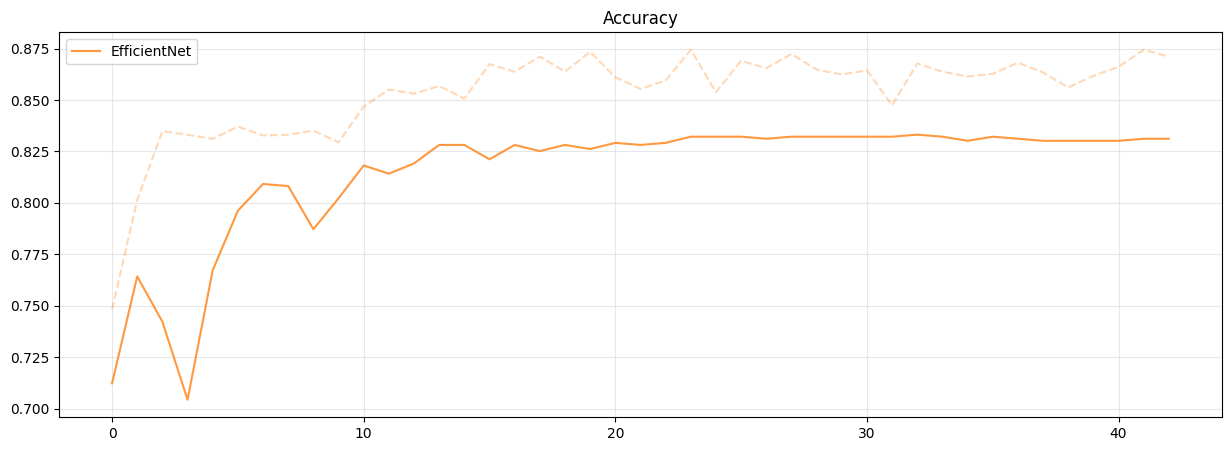

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='EfficientNet', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
def unfreeze_model(model):
    # We unfreeze the last 20 layers leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

# Assuming you already have a model created using build_model function and you want to unfreeze it
unfreeze_model(model)



In [ ]:
# Train the model
history = model.fit(
    x = (X_train),
    y = y_train,
    batch_size = 256,
    shuffle=True,
    epochs = 100,
    validation_data = ((X_val), y_val),
    callbacks = callbacks
).history

Epoch 1/100
12/12 [==============================] - 20s 788ms/step - loss: 0.3391 - accuracy: 0.8631 - val_loss: 0.4148 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 2/100
12/12 [==============================] - 2s 205ms/step - loss: 0.3138 - accuracy: 0.8784 - val_loss: 0.4108 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 3/100
12/12 [==============================] - 2s 208ms/step - loss: 0.2996 - accuracy: 0.8831 - val_loss: 0.4113 - val_accuracy: 0.8292 - lr: 1.0000e-04
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.2949 - accuracy: 0.8871
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
12/12 [==============================] - 2s 208ms/step - loss: 0.2949 - accuracy: 0.8871 - val_loss: 0.4127 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 5/100
12/12 [==============================] - 3s 225ms/step - loss: 0.2801 - accuracy: 0.8951 - val_loss: 0.4091 - val_accuracy: 0.8332 - lr: 2.0000e-05
Epoch 6/100
12/12 [====================

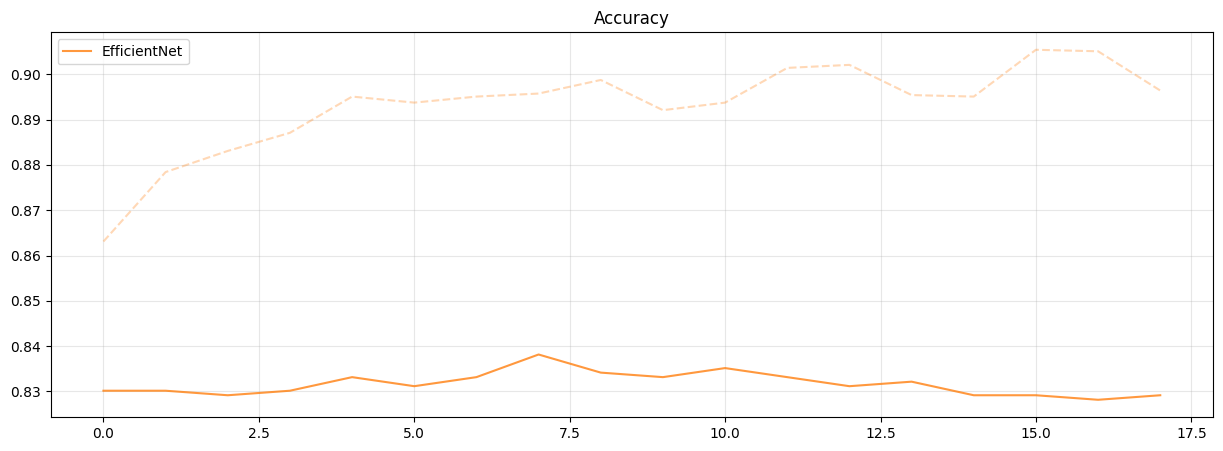

In [ ]:
# Plot the training

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='EfficientNet', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# model.load_weights('CustomModel.weights.hdf5')

In [ ]:
# Evaluate the model on the test set
# test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
test_accuracy = model.evaluate(X_test,y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8681


In [ ]:
model.save('EfficientNetB1_v2')

## Additional methods to improve accuracy

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

 datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    vertical_flip = True,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    validation_split=0.25
)

# Apply data augmentation only to the training set
datagen.fit(X_train_val)

### Ensambling models

In [ ]:
# custom_model = tfk.models.load_model('FineTunedMobilevnet_v3_withCallbacks_andShuffle')
efficientNet_model1 = tfk.models.load_model('EfficientNetB1_v2')
efficientNet_model = tfk.models.load_model('EfficientNet')
efficientNet_model2 = tfk.models.load_model('KFoldCrossVal_EfficientNetB2')

In [ ]:
# concatenate the models

# import  layers
from tensorflow.keras.layers import Concatenate, Average, Dropout, Dense


# get list of models
models = [efficientNet_model2, efficientNet_model1, efficientNet_model]

input = tfk.Input(shape=(96, 96, 3), name='input') # input layer

# get output for each model input
outputs = [model(input) for model in models]

# take average of the outputs
x = Average()(outputs)

# add further layers
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid', name='output')(x) # output layer

# create concatenated model
avg_model = tfk.Model(input, output, name= 'Concatenated_Model')

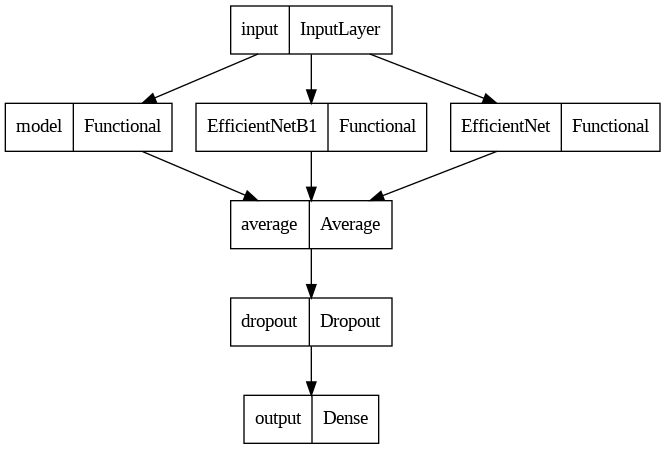

In [ ]:
# show model structure
from tensorflow.keras.utils import plot_model

plot_model(avg_model)

In [ ]:
#finetuning
for i, layer in enumerate(avg_model.layers):
  avg_model.get_layer(layer.name).trainable = False

avg_model.get_layer("output").trainable = True
avg_model.get_layer("dropout").trainable = True
avg_model.get_layer("average").trainable = True

for i, layer in enumerate(avg_model.layers):
  print(i, layer.name, layer.trainable)

0 input False
1 model False
2 EfficientNetB1 False
3 EfficientNet False
4 average True
5 dropout True
6 output True


In [ ]:
avg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss="binary_crossentropy",  # Change to "categorical_crossentropy" for multi-class
    metrics=["accuracy"]
)

In [ ]:
# Train the model on the  WHOLE dataset
history = avg_model.fit(
    x = X_train,
    # x = X_train_val,
    y = y_train,
    # y = y_train_val,
    batch_size = 128,
    shuffle=True,
    epochs = 100,
    validation_data = (X_val, y_val),
    # validation_data = (X_test, y_test),
    callbacks = callbacks
).history

Epoch 1/100
24/24 [==============================] - 44s 686ms/step - loss: 0.6491 - accuracy: 0.6079 - val_loss: 0.6061 - val_accuracy: 0.8142 - lr: 0.0100
Epoch 2/100
24/24 [==============================] - 6s 274ms/step - loss: 0.6092 - accuracy: 0.7458 - val_loss: 0.5648 - val_accuracy: 0.8941 - lr: 0.0100
Epoch 3/100
24/24 [==============================] - 8s 331ms/step - loss: 0.5675 - accuracy: 0.8005 - val_loss: 0.5286 - val_accuracy: 0.9091 - lr: 0.0100
Epoch 4/100
24/24 [==============================] - 8s 319ms/step - loss: 0.5456 - accuracy: 0.8148 - val_loss: 0.5006 - val_accuracy: 0.9111 - lr: 0.0100
Epoch 5/100
24/24 [==============================] - 8s 333ms/step - loss: 0.5297 - accuracy: 0.8281 - val_loss: 0.4781 - val_accuracy: 0.9171 - lr: 0.0100
Epoch 6/100
24/24 [==============================] - 6s 257ms/step - loss: 0.5101 - accuracy: 0.8311 - val_loss: 0.4588 - val_accuracy: 0.9151 - lr: 0.0100
Epoch 7/100
24/24 [==============================] - 7s 282ms/s

In [ ]:
# Evaluate the model on the test set
# test_accuracy_custom = custom_model.evaluate((X_test),y_test,verbose=0)[-1]
test_accuracy = avg_model.evaluate((X_test),y_test,verbose=0)[-1]

print('Test set accuracy %.4f' % test_accuracy)


Test set accuracy 0.8931


In [ ]:
avg_model.save('Avg_b0_b2_b1_crossVal_alldata')

### K-fold cross validation

In [ ]:
from tensorflow.keras.applications import EfficientNetB0,EfficientNetB1, EfficientNetB2
from tensorflow.keras import layers, models

In [ ]:
def unfreeze_model(model):
    # We unfreeze the last 20 layers leaving BatchNorm layers frozen
    for layer in model.layers[-30:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )



In [ ]:
X=X_train_val
y=y_train_val

In [ ]:
model = tfk.models.load_model('EfficientNetB2_v2')

unfreeze_model(model)

In [ ]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)
# model.summary()

0 input_1 True
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block1b_dwconv False
19 block1b_bn False
20 block1b_activation False
21 block1b_se_squeeze False
22 block1b_se_reshape False
23 block1b_se_reduce False
24 block1b_se_expand False
25 block1b_se_excite False
26 block1b_project_conv False
27 block1b_project_bn False
28 block1b_drop False
29 block1b_add False
30 block2a_expand_conv False
31 block2a_expand_bn False
32 block2a_expand_activation False
33 block2a_dwconv_pad False
34 block2a_dwconv False
35 block2a_bn False
36 block2a_activation False
37 block2a_se_squeeze False
38 block2a_se_reshape False
39 block2a_se_reduce Fa

In [ ]:
#Importing the KFold module from sklearn for evaluation
from sklearn.model_selection import KFold

k =5

kf = KFold(n_splits=k, random_state=True, shuffle=True)

n_classes=2

for train_index, val_index in kf.split(X) :
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    history = model.fit(
    # x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    x = (X_train),
    y = y_train,
    batch_size = 256,
    epochs = 200,
    # validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    validation_data = ((X_val), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    shuffle=True,
    callbacks = callbacks,
    class_weight={0: class_weights[0], 1: class_weights[1]} # can comment this line if don't want to have weighted classes
    ).history


Epoch 1/200
13/13 [==============================] - 27s 452ms/step - loss: 0.5295 - accuracy: 0.9041 - val_loss: 0.2402 - val_accuracy: 0.9176 - lr: 1.0000e-04
Epoch 2/200
13/13 [==============================] - 1s 93ms/step - loss: 0.4594 - accuracy: 0.9163 - val_loss: 0.2519 - val_accuracy: 0.9101 - lr: 1.0000e-04
Epoch 3/200
13/13 [==============================] - 1s 94ms/step - loss: 0.4542 - accuracy: 0.9194 - val_loss: 0.2722 - val_accuracy: 0.8951 - lr: 1.0000e-04
Epoch 4/200
12/13 [==========================>...] - ETA: 0s - loss: 0.4353 - accuracy: 0.9186
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
13/13 [==============================] - 1s 93ms/step - loss: 0.4343 - accuracy: 0.9185 - val_loss: 0.2567 - val_accuracy: 0.9001 - lr: 1.0000e-04
Epoch 5/200
13/13 [==============================] - 1s 94ms/step - loss: 0.3740 - accuracy: 0.9354 - val_loss: 0.2414 - val_accuracy: 0.9126 - lr: 2.0000e-05
Epoch 6/200
13/13 [========================

In [ ]:
# Evaluate the model on the test set
# test_accuracy = ft_model.evaluate(preprocess_input(X_test),y_test,verbose=0)[-1]
test_accuracy = model.evaluate(X_test,y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8601


In [ ]:
model.save('KFoldCrossVal_EfficientNetB2')

## Loading and testing the model

In [ ]:
submission_model=tf.keras.models.load_model('FineTuningMobilevnet_v2_vne')

In [ ]:
# Predict labels for the entire test set
predictions = submission_model.predict((preprocess_input(X_test)), verbose=0)
y_pred=np.round(predictions)

# Display the shape of the predictions
print("Predictions Shape:", y_pred.shape)

accuracy = accuracy_score(y_test, y_pred)
accuracy

In [ ]:
# Compute the confusion matrix

cm = confusion_matrix(y_test, y_pred)

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(results_labels.values()), yticklabels=list(results_labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Submission - test

In [ ]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.mobilenet import preprocess_input

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'TransferLearningModel_v2'))

    def predict(self, X):

        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(preprocess_input(X_test), verbose=0)
        out = np.round(out)  # Shape [BS] #for sigmoid
        out=out.reshape((out.shape[0],))
        out = tf.convert_to_tensor(out)

        return out

In [ ]:
model = model('/gdrive/My Drive/Colab Notebooks/ANN challenge')
predictions=model.predict(X_test)
accuracy = accuracy_score(y_test,predictions)
accuracy

In [ ]:
# # out = np.round(])
# print(out.shape)

# out.reshape((out.shape[0],))

In [ ]:
del model